## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

# <center> **Часть II. Разведывательный анализ и моделирование.**

Импорт библиотек

In [46]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.stats as sm 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest

from functions import *

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

## Данные

Читаем данные

In [47]:
data = pd.read_csv('data/data_edited.csv')

data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.537500,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.326667,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.960000,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.752500,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.080000,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.250000,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.600000,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.143333,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.605000,4,0.48,1,1,0,9,0,0,528.000


In [48]:
get_data_info(data)

,Nulls,Uniques,Dtypes
status for sale,0.0,2,int64
status coming soon,0.0,2,int64
status new,0.0,2,int64
status foreclosure,0.0,2,int64
status pre-foreclosure,0.0,2,int64
...,...,...,...
schools with preschool,0.0,11,int64
school grades,0.0,13,int64
target per month,0.0,2,int64
target plus,0.0,2,int64


## Разведывательный анализ

### *Исследование бинарных переменных*

In [49]:
bin_cols = set()
num_cols = []

for col in data.columns:
    if ('target' not in col) and (data[col].nunique() == 2):
        bin_cols.add(col.split()[0])
    else:
        num_cols.append(col)

bin_cols, num_cols

({'cooling', 'heating', 'parking', 'propertyType', 'status'},
 ['baths',
  'beds',
  'sqft area',
  'property age',
  'property remodeled',
  'p. spaces',
  'lotsize',
  'zipcode national area',
  'zipcode sectional center',
  'zipcode delivery area',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school rating nearest',
  'school distance to best',
  'schools with k',
  'schools with pk',
  'schools with preschool',
  'school grades',
  'target per month',
  'target plus',
  'target'])

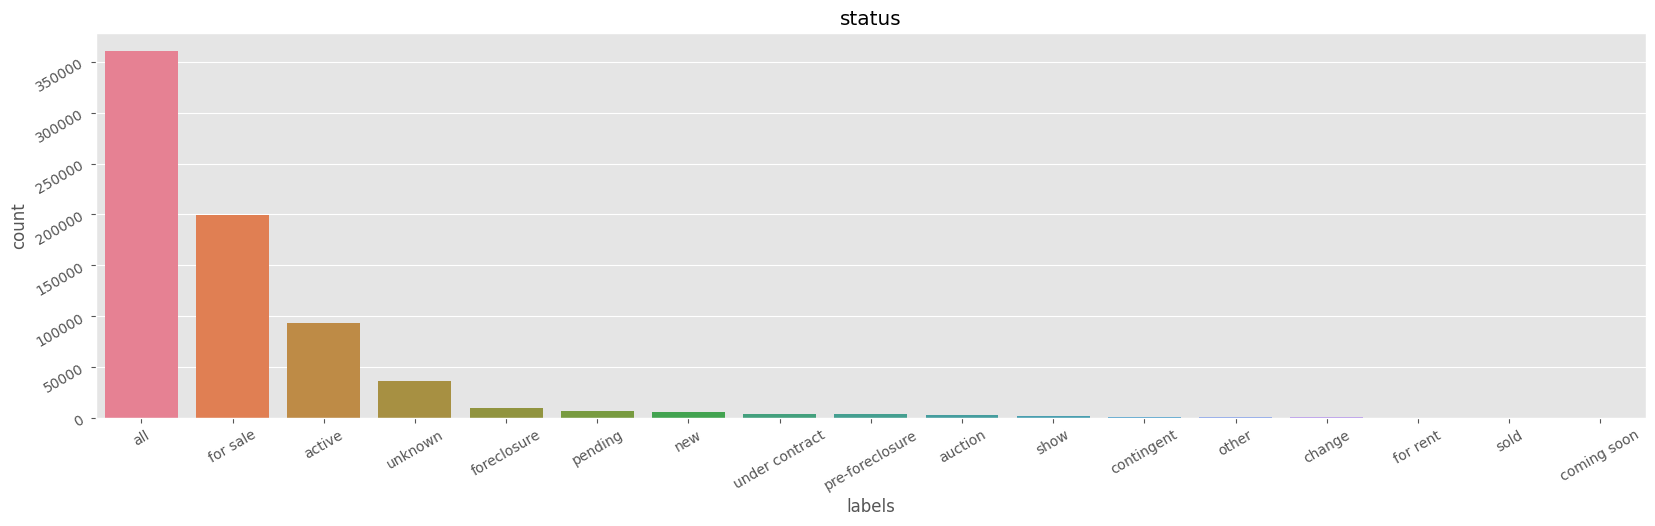

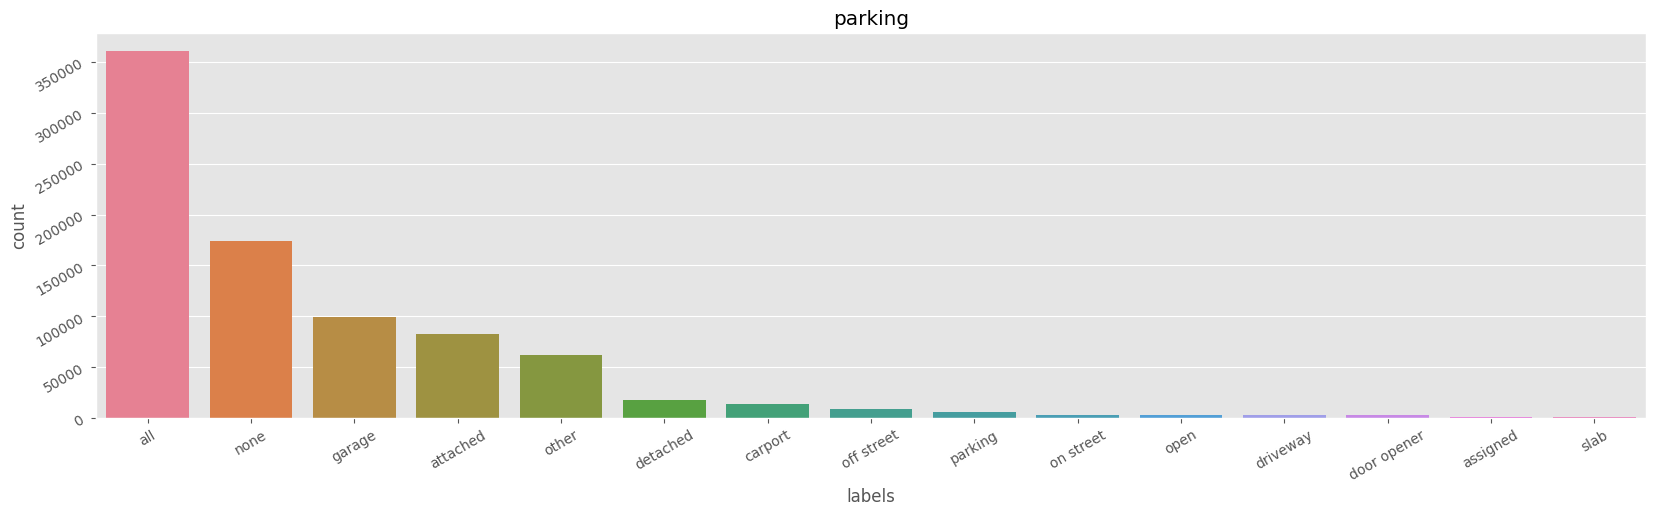

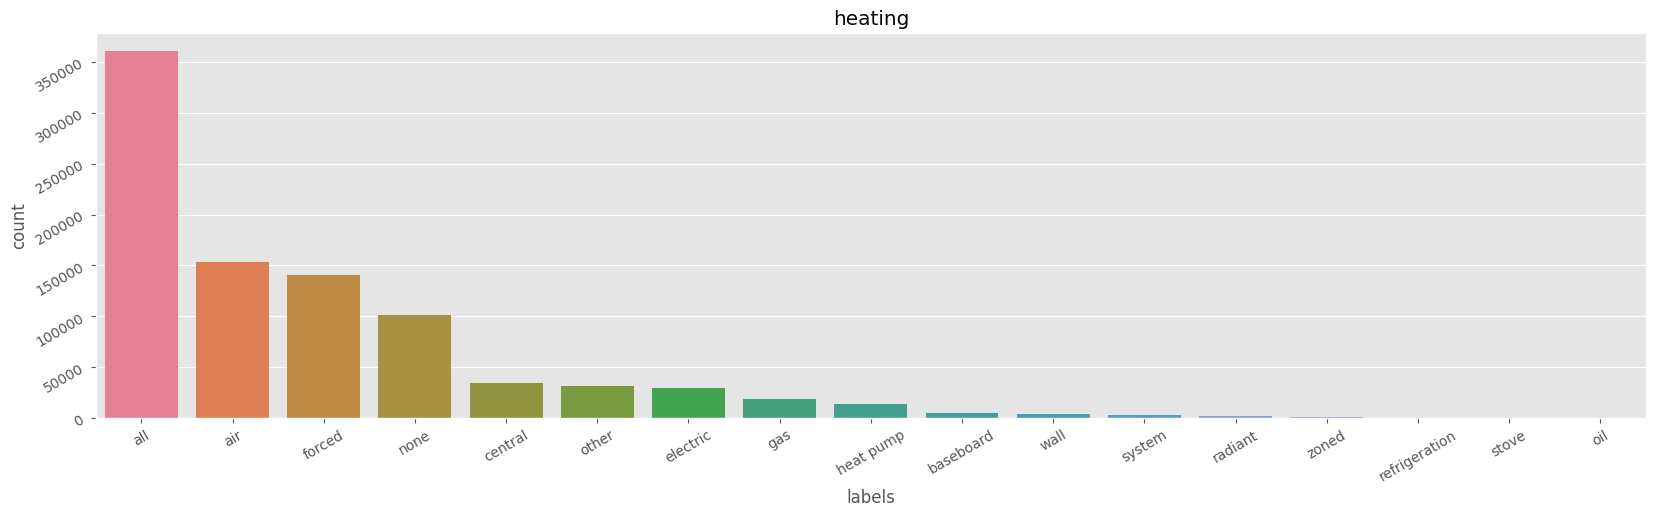

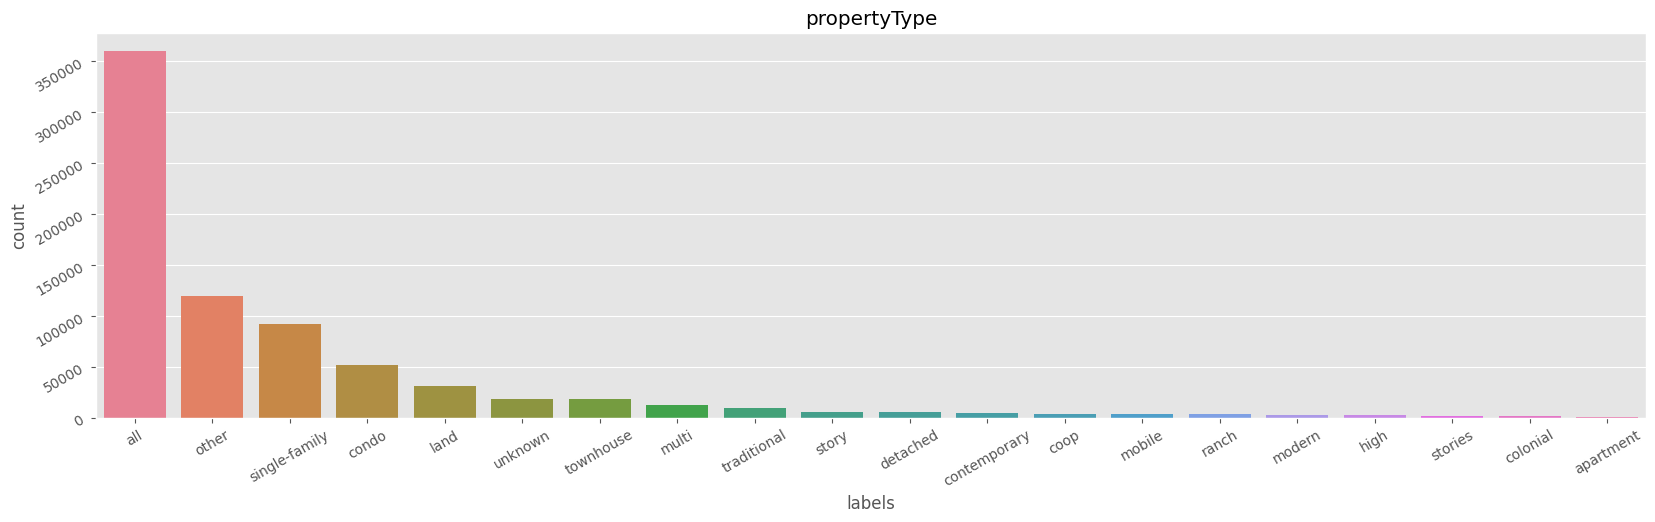

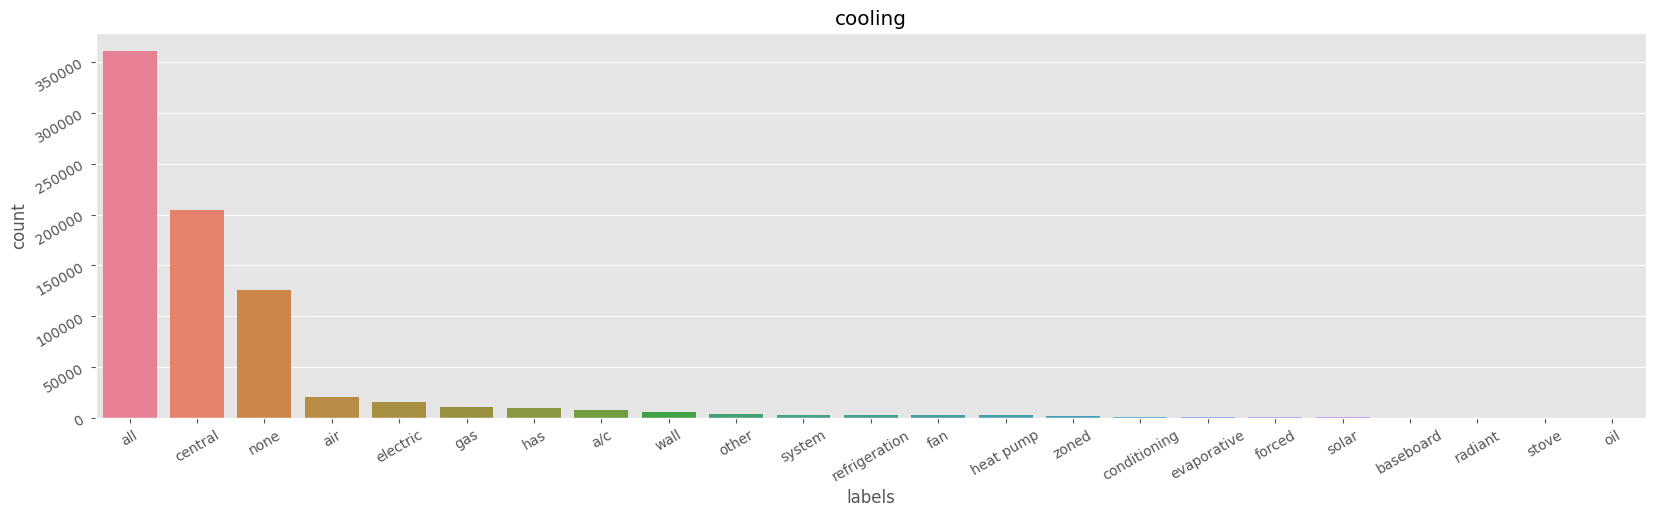

In [50]:
def show_barplot(cols, data=data, figsize=(20, 5)):
    sums = get_sums(data, cols).sort_values(ascending=False)

    col_list = sums.index.tolist() + ['all']
    vls_list = sums.values.tolist() + [data.shape[0]]

    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(cols+' ', '')

    df = (pd.DataFrame({'labels': col_list, 
                        'count': vls_list})
          .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(df, x='labels', y='count', hue='labels', ax=ax)
    ax.tick_params(rotation=30)
    ax.set_title(cols)
    
    return fig 


for col in bin_cols:
    show_barplot(col).show()

### *Проверка на нормальность*

In [51]:
def test_normality(labels, 
                   data=data, 
                   testfunc='shapiro', 
                   alpha=0.05):
    
    norm_df = pd.DataFrame(index=labels)
    
    pv_list = []
    for col in data[labels].columns:
        x = data[col]
        
        if testfunc == 'dagostino':
            p = ss.normaltest(x)
            pv = round(p.pvalue[0], 3)
            alpha = alpha / 2

        p = ss.shapiro(x)
        pv = round(p.pvalue, 3)
        
        pv_list.append(pv)
    
    norm_df['p_value'] = pv_list
    norm_df['is_normal'] = norm_df['p_value'].apply(lambda x: 0 if x > alpha else 1)

    return norm_df

In [52]:
test_normality(num_cols)

,p_value,is_normal
baths,0.0,1
beds,0.0,1
sqft area,0.0,1
property age,0.0,1
property remodeled,0.0,1
p. spaces,0.0,1
lotsize,1.0,0
zipcode national area,0.0,1
zipcode sectional center,0.0,1
zipcode delivery area,0.0,1


### *Выявление и очистка выбросов* 

In [53]:
def fix_data(feature, data=data, figsize=(20, 7)):
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    
    
    x = data[feature]
    
    sns.boxplot(x=x, fill=False, ax=ax[0, 0])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('box')
    ax[0, 0].set_title(feature+' original')

    sns.histplot(x=x, bins=x.nunique(), ax=ax[1, 0])
    ax[1, 0].set_xlabel('')
    ax[1, 0].set_ylabel('hist')
    
    sns.kdeplot(x=x, ax=ax[2, 0])
    ax[2, 0].set_xlabel('')
    ax[2, 0].set_ylabel('kde')


    lim = x.quantile(0.99)
    fixed = data[x <= lim][x >= -lim].reset_index(drop=True)
    
    xnew = fixed[feature]
    
    sns.boxplot(x=xnew, fill=False, ax=ax[0, 1])
    ax[0, 1].set_xlabel('')
    ax[0, 1].set_ylabel('box')
    ax[0, 1].set_title(feature+' fixed')
    
    sns.histplot(x=xnew, bins=xnew.nunique(), ax=ax[1, 1])
    ax[1, 1].set_xlabel('')
    ax[1, 1].set_ylabel('hist')
    
    sns.kdeplot(x=xnew, ax=ax[2, 1])
    ax[2, 1].set_xlabel('')
    ax[2, 1].set_ylabel('kde')
    
    fig.show()
    print(f'{fixed.shape[0]} rows X {fixed.shape[1]} cols')
    
    return fixed

357192 rows X 110 cols


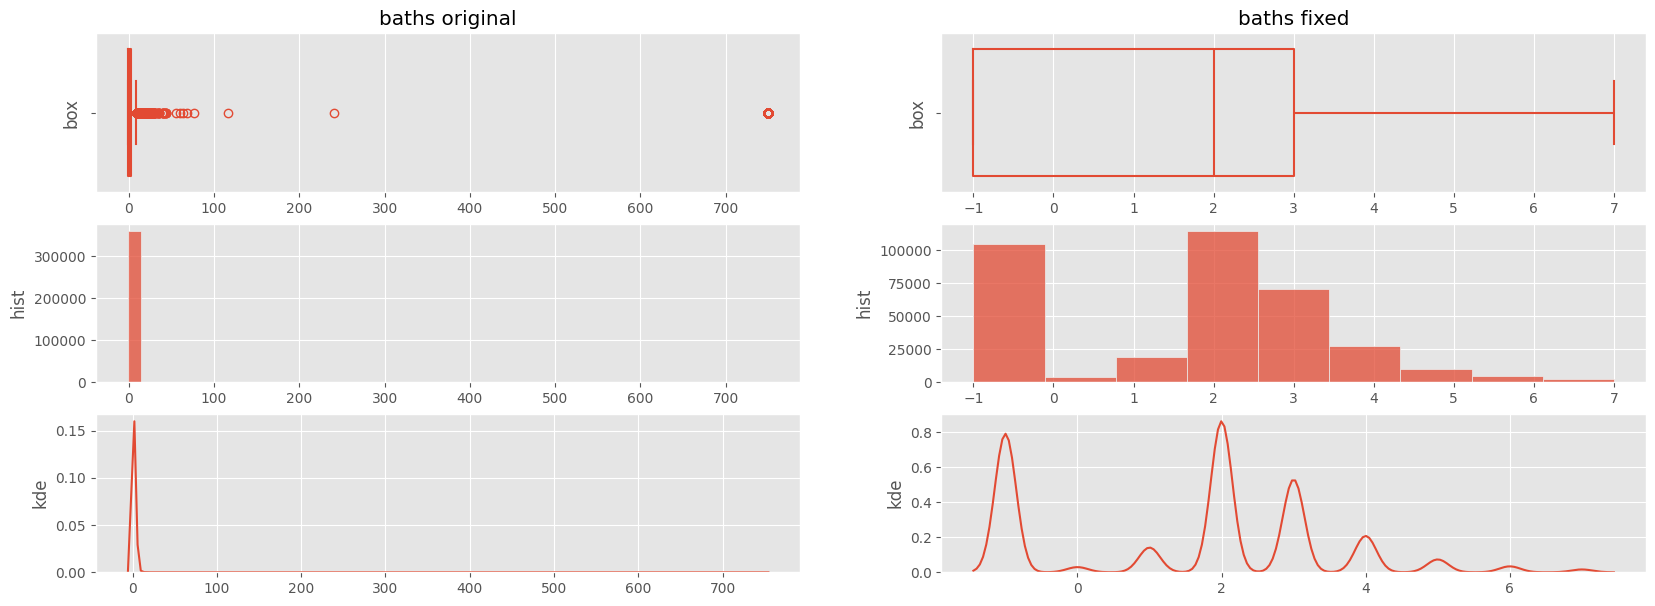

In [54]:
fixed_data = fix_data('baths')

353996 rows X 110 cols


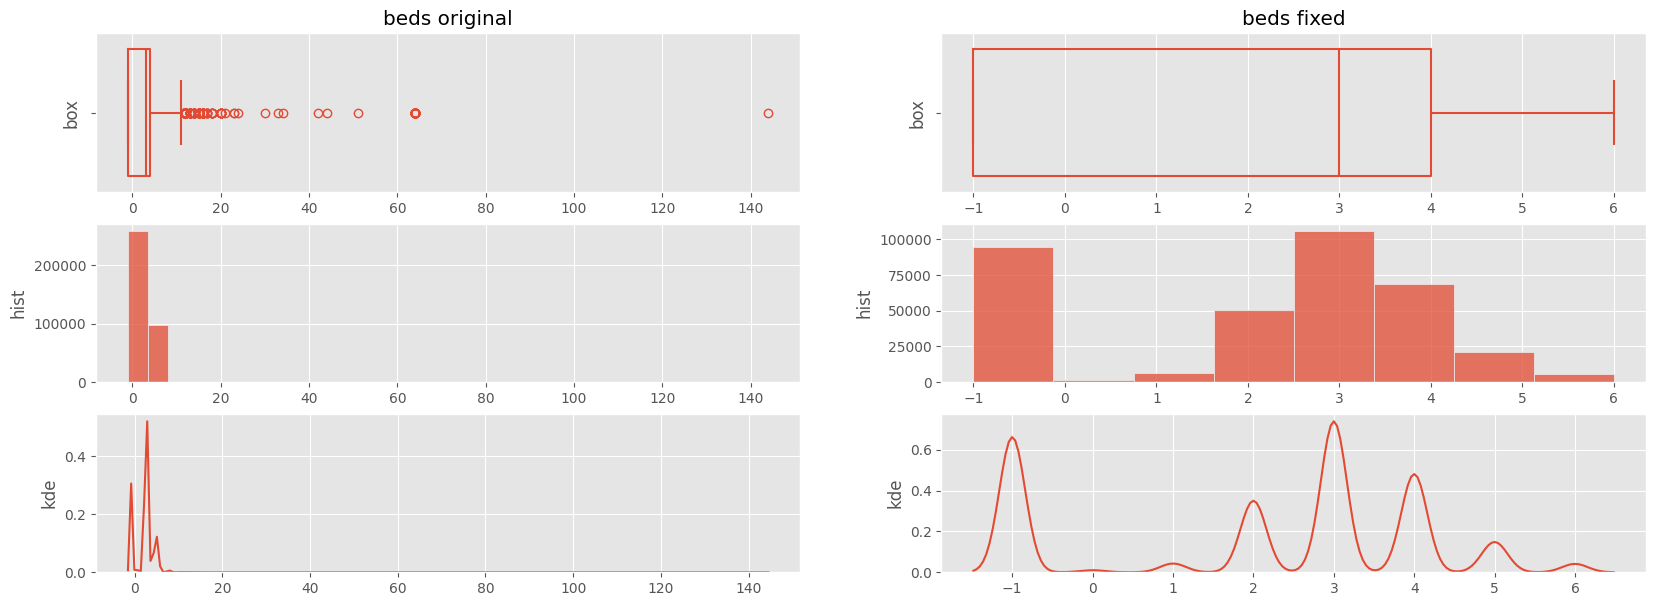

In [55]:
fixed_data = fix_data('beds', data=fixed_data)

350456 rows X 110 cols


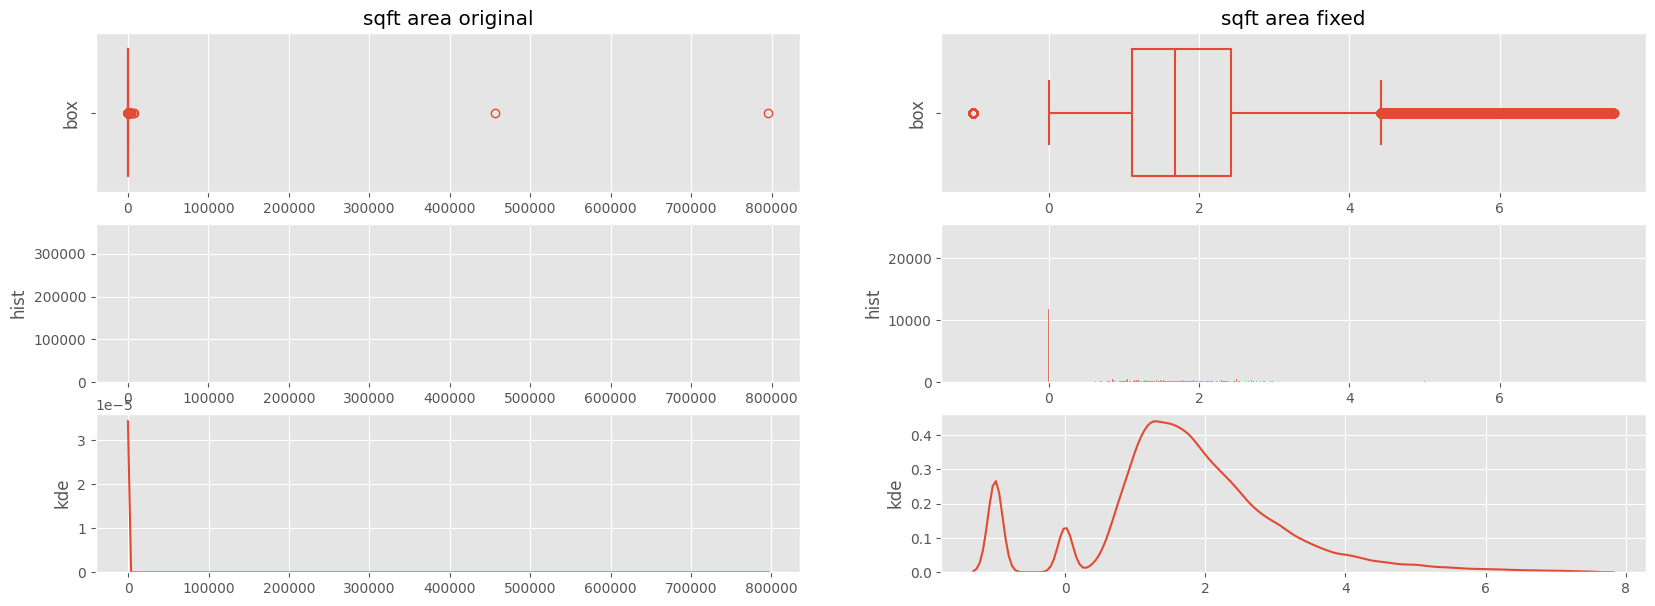

In [56]:
fixed_data = fix_data('sqft area', data=fixed_data) 

347098 rows X 110 cols


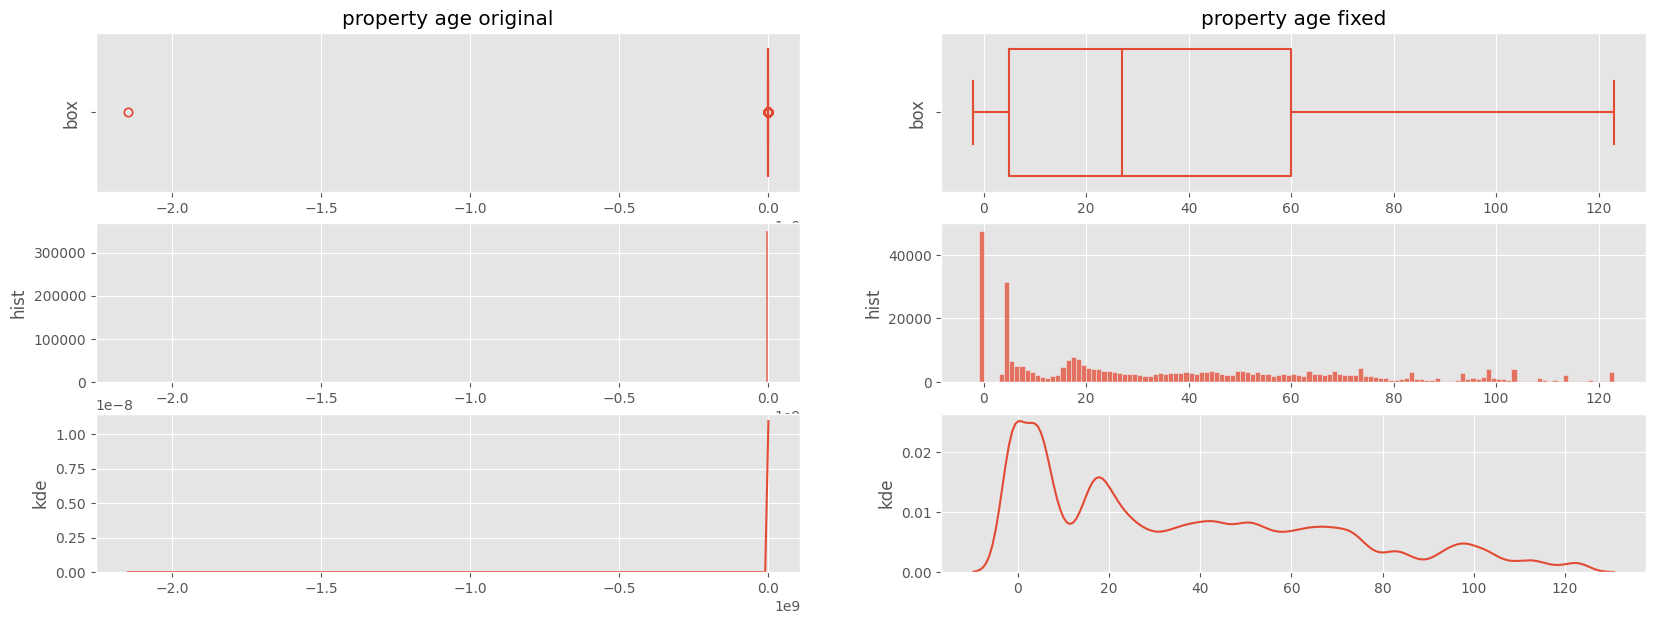

In [57]:
fixed_data = fix_data('property age', data=fixed_data)

343702 rows X 110 cols


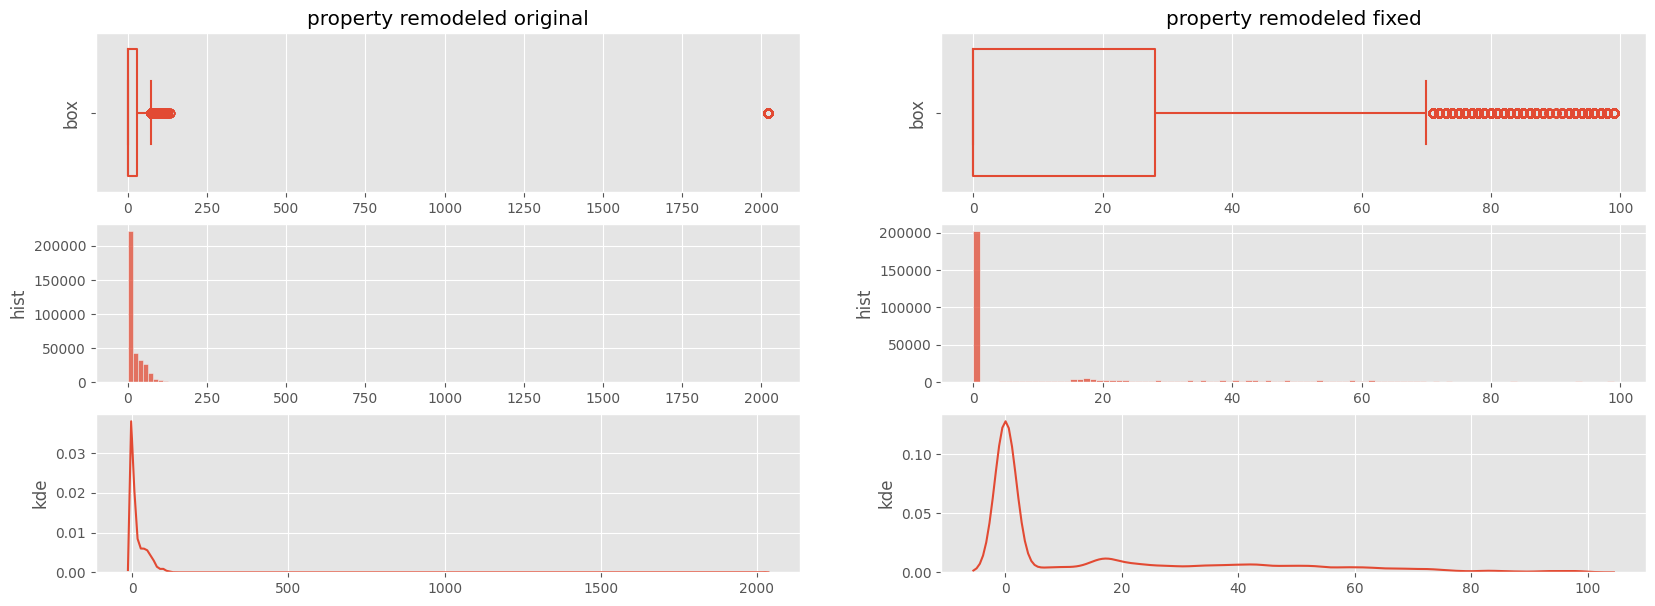

In [58]:
fixed_data = fix_data('property remodeled', data=fixed_data) 

341530 rows X 110 cols


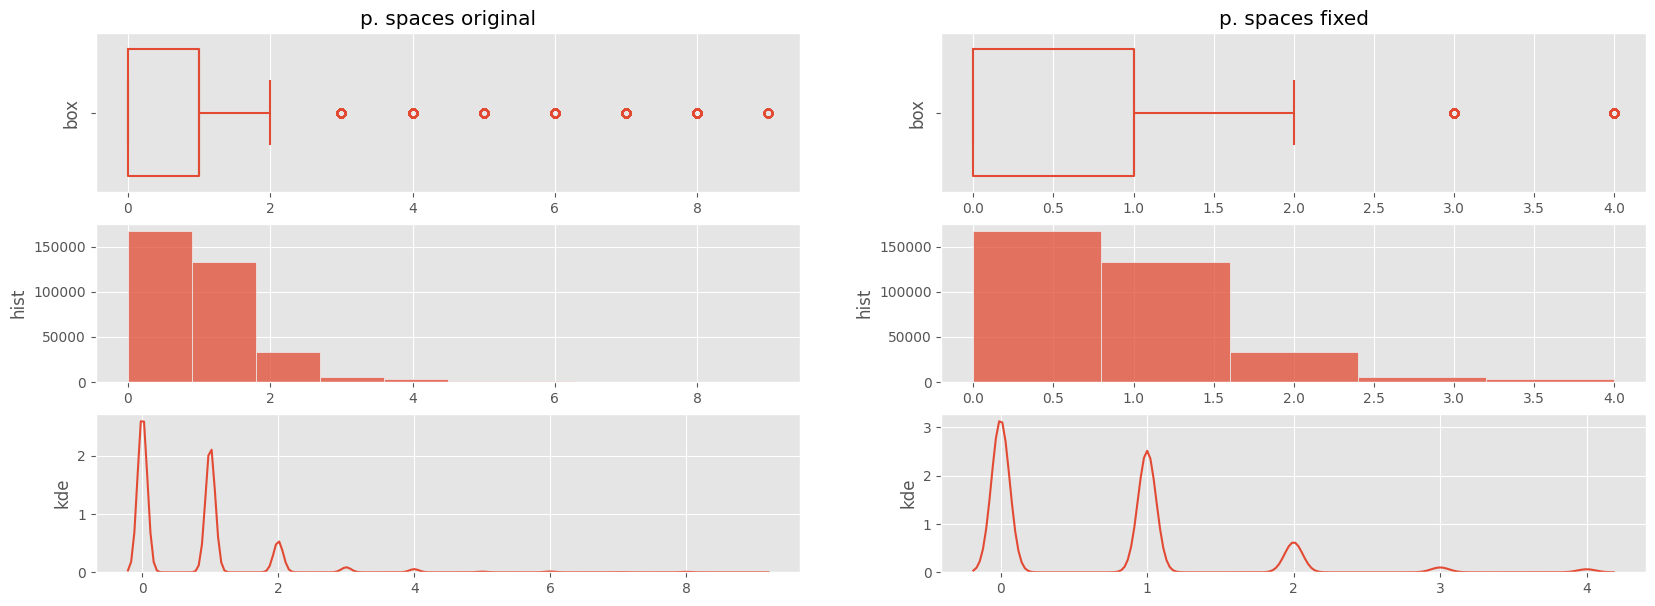

In [59]:
fixed_data = fix_data('p. spaces', data=fixed_data)

336917 rows X 110 cols


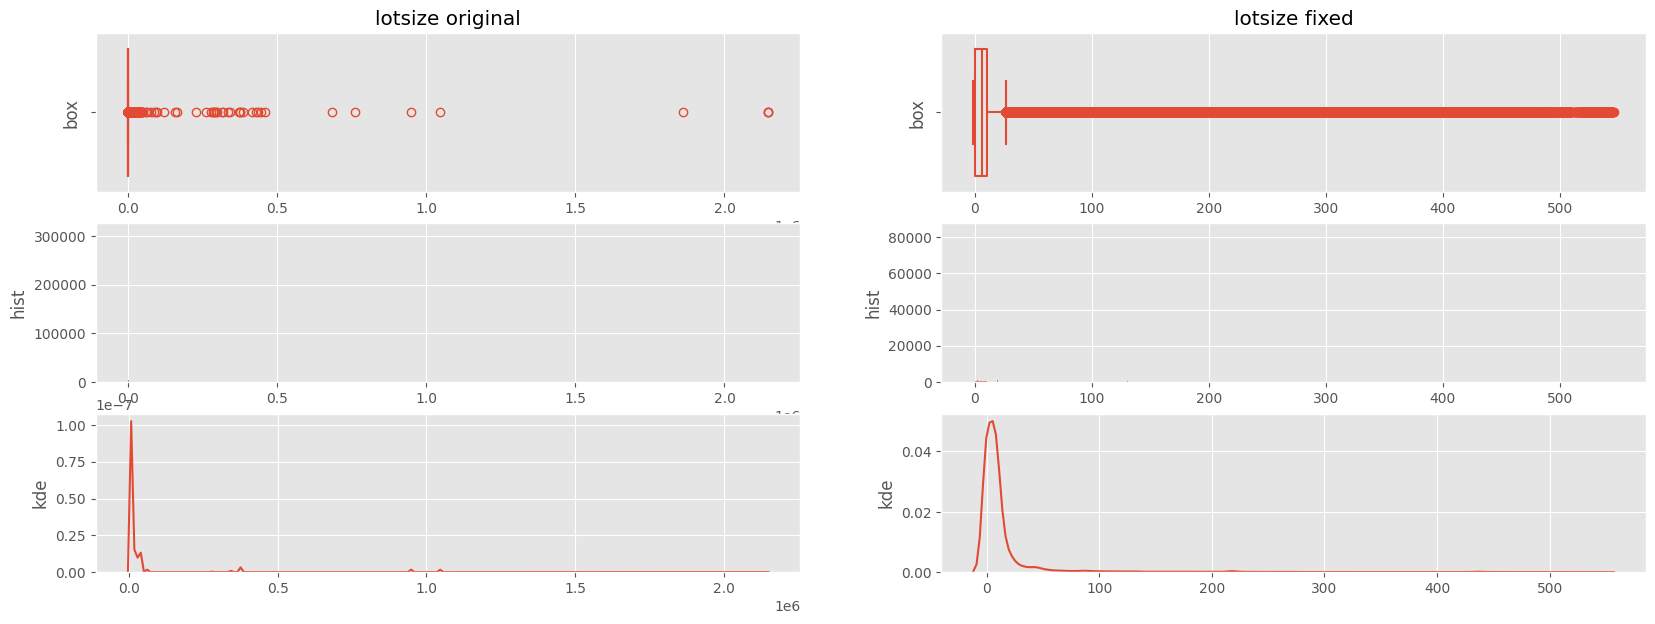

In [60]:
fixed_data = fix_data('lotsize', data=fixed_data)

333564 rows X 110 cols


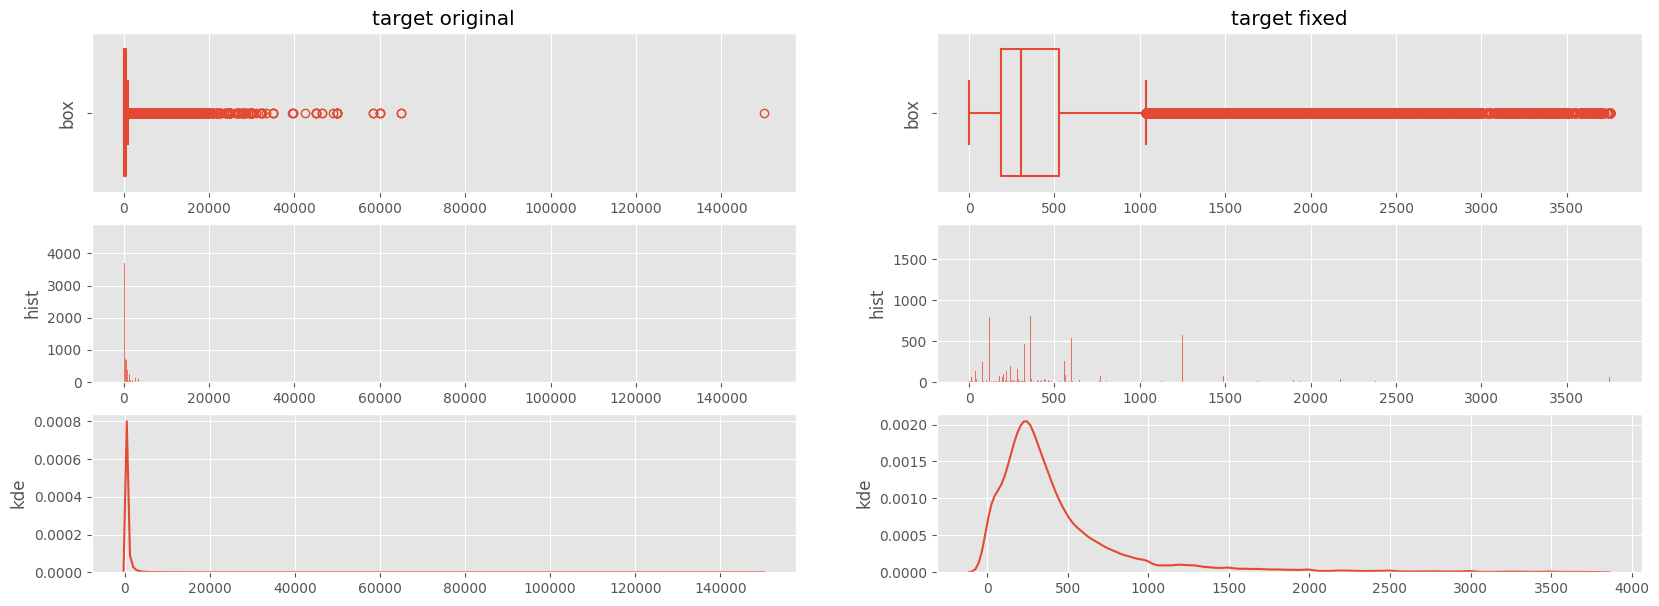

In [61]:
fixed_data = fix_data('target', data=fixed_data)

### *Исследование почтового индекса*

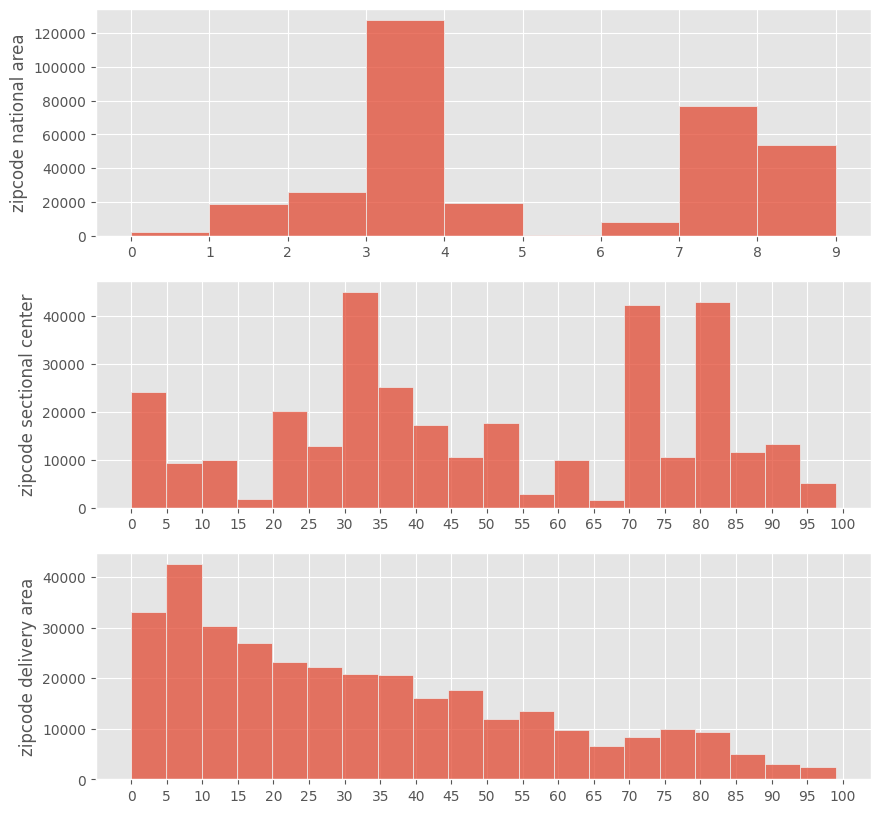

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))


ziplist = ['zipcode national area', 
           'zipcode sectional center', 
           'zipcode delivery area']

for i, col in enumerate(ziplist):
    x = fixed_data[col]
    
    if i == 0:
        bins = 9
    else:
        bins = 20
    
    sns.histplot(x=x, bins=bins, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel(col)

ax[0].set_xticks(range(10))
ax[1].set_xticks(range(0, 101, 5))
ax[2].set_xticks(range(0, 101, 5))
    
fig.show()

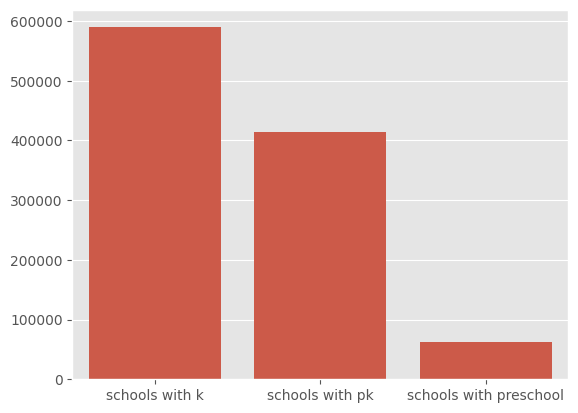

In [63]:
sns.barplot(get_sums(fixed_data, 'schools with'))
plt.show()

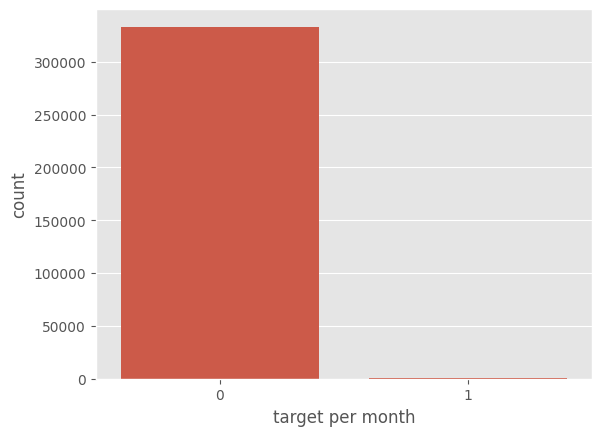

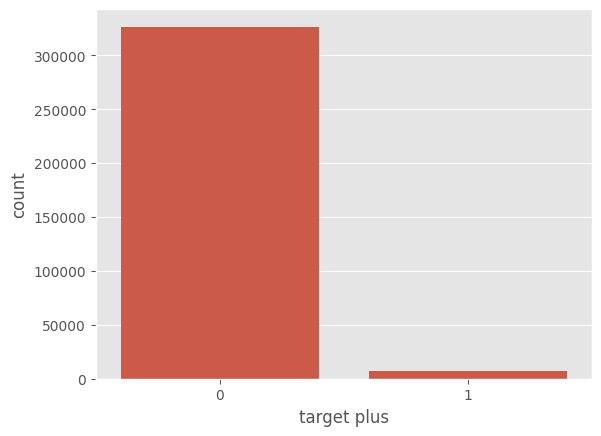

In [64]:
for col in ['target per month', 'target plus']:
    sns.barplot(get_vc(fixed_data[col]))
    plt.show()

### *Проверка на мультиколлинеарность*

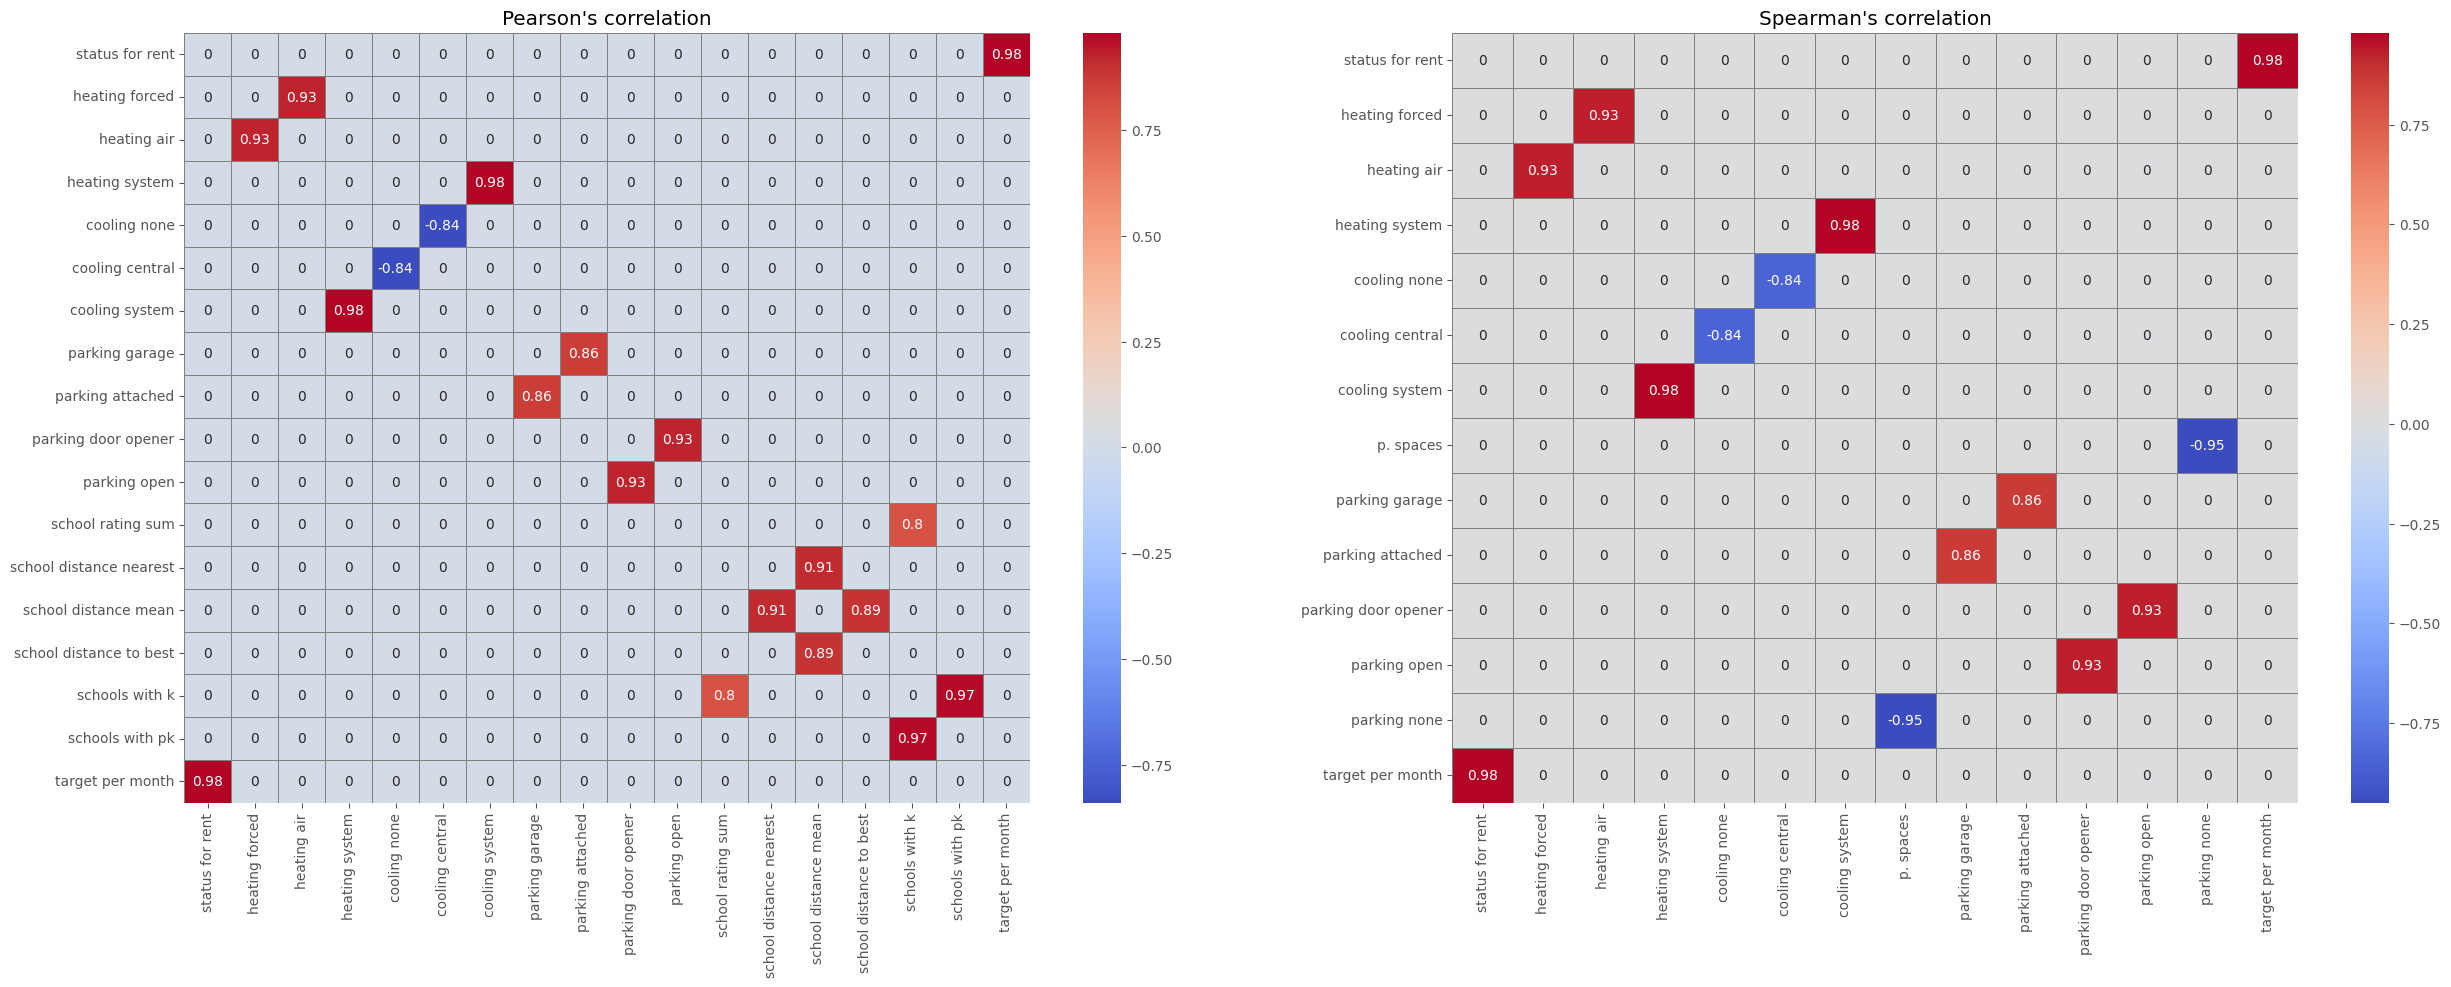

In [65]:
def get_correlations(method, data=fixed_data):
    corr_data = (data.corr(method=method)
                 [data.corr(method=method).abs() > 0.8]
                 .round(2))

    for i in corr_data.index:
        for c in corr_data.columns:
            if i == c:
                corr_data.loc[i, c] = np.nan
            
    corr_data.fillna(0, inplace=True)

    for i, c in zip(corr_data.index, 
                    corr_data.columns):
        if corr_data.loc[i].sum() == 0:
            corr_data.drop(i, axis=0, inplace=True)
        if corr_data.loc[:, c].sum() == 0:
            corr_data.drop(c, axis=1, inplace=True)
            
    return corr_data


corr_data_pearson = get_correlations('pearson', data)
corr_data_spearman = get_correlations('spearman', data)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))

sns.heatmap(corr_data_pearson, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[0])
ax[0].set_title("Pearson's correlation")

sns.heatmap(corr_data_spearman, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[1])
ax[1].set_title("Spearman's correlation")
    
fig.show()

In [66]:
multicollinear_cols = ['status for rent', 'heating forced', 
                       'cooling system', 'cooling none', 
                       'parking garage', 'parking none', 
                       'parking door opener', 'school rating nearest',
                       'school distance to best', 'school rating sum',
                       'schools with pk']

fixed_data.drop(multicollinear_cols, axis=1, inplace=True)

fixed_data.shape 

(333564, 99)

### *Исследования по выборкам*

In [67]:
sample_1 = fixed_data[fixed_data['status for sale'] == 1]
sample_0 = fixed_data[fixed_data['status for sale'] == 0]

_, p = ss.mannwhitneyu(sample_0['target'], sample_1['target'])

alpha = 0.05

if p > alpha:
    print(f'Признак цены недвижимости не зависит от признака {}')
else:
    print('ni')
    
print(p)

ni
2.1361386549811326e-62


In [ ]:
for col in fixed_data.columns:
    pass

In [69]:
bin_cols

{'cooling', 'heating', 'parking', 'propertyType', 'status'}

In [68]:
fixed_data.columns.tolist()

['status for sale',
 'status coming soon',
 'status new',
 'status foreclosure',
 'status pre-foreclosure',
 'status pending',
 'status auction',
 'status active',
 'status show',
 'status sold',
 'status under contract',
 'status contingent',
 'status change',
 'status unknown',
 'status other',
 'propertyType single-family',
 'propertyType condo',
 'propertyType land',
 'propertyType townhouse',
 'propertyType multi',
 'propertyType coop',
 'propertyType traditional',
 'propertyType ranch',
 'propertyType mobile',
 'propertyType detached',
 'propertyType contemporary',
 'propertyType modern',
 'propertyType apartment',
 'propertyType story',
 'propertyType stories',
 'propertyType high',
 'propertyType colonial',
 'propertyType other',
 'propertyType unknown',
 'baths',
 'beds',
 'sqft area',
 'property age',
 'property remodeled',
 'heating air',
 'heating none',
 'heating electric',
 'heating gas',
 'heating heat pump',
 'heating central',
 'heating baseboard',
 'heating wall',
 'h